In [19]:
import sys  
sys.path.insert(1, './../../../ESN-IP/IP/.')

import random

random.seed(10)

from DATA import InubushiErgodic

data = InubushiErgodic(ni=-1)
data.delay_timeseries(1)
data.split([80,0,20])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()


In [20]:
import matplotlib.pyplot as plt

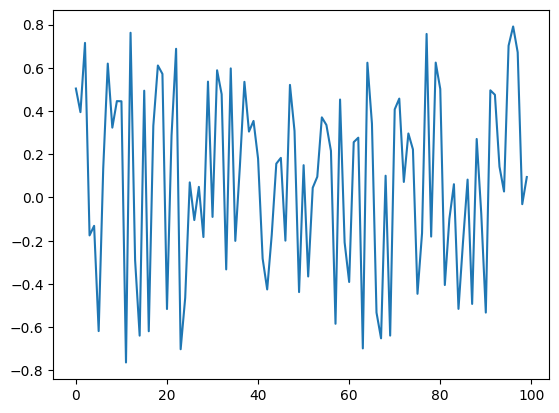

In [21]:
data.X_FULL.shape

plt.plot(data.X_TS[0:100])

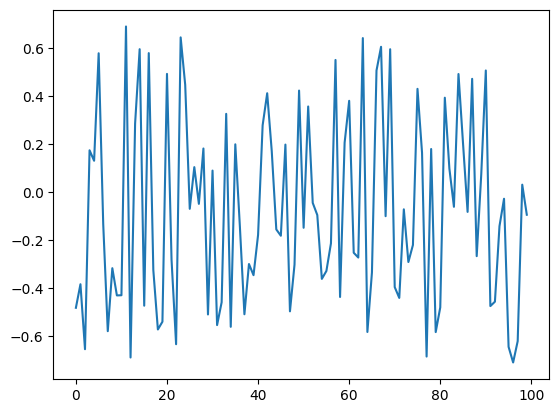

In [22]:
plt.plot(data.Y_TS[0:100])

In [23]:
from Metrics import MSE
from IPReservoir import IPReservoir
from ESN import Reservoir, EchoStateNetwork
from IntrinsicPlasticity import IPMask, IPDistribution

N_UNITS_LIST = [100, 150, 200, 250]
W_range=(-0.5, 0.5)
initial_rho = 0.5
desired_rhos = [0.95, 0.95, 0.95, 0.95]
bias_range = [-0.1, 0.1]

In [24]:
REPETITIONS = 5
max_epochs = 15 
columns = ["Name", "TYPE", "MSE", "MC", "Lambda max", "delta_phI", "KL", "Rho", "A-Norm", "B-Norm"]
models_num = len(N_UNITS_LIST)*len(desired_rhos)
rows = []

for N_UNITS, desired_rho in zip(N_UNITS_LIST, desired_rhos):
    config_string = f"{N_UNITS} UNIT - Spectral Radius: {desired_rho}"
    names = ["Vanilla", "Gauss 1", "Gauss 2", "Bimodal", "Trim 1", "Trim 2", "Trim 3"]
    identifiers = [ f"- {name} - {config_string} " for name in names]
    
    for R in range(REPETITIONS):
        vanilla_reservoir = Reservoir(N = N_UNITS, ro_rescale = desired_rho, W_range=W_range, bias_range=bias_range)
        
        gaussian_reservoir_1 = IPReservoir(N = N_UNITS, ro_rescale=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.gaussian(N_UNITS, 0.5, apply_activation=True))
        gaussian_reservoir_2 = IPReservoir(N = N_UNITS, ro_rescale=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.gaussian(N_UNITS, 0.25, apply_activation=True))

        bimodal_reservoir = IPReservoir(N = N_UNITS, ro_rescale=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.mixedBimodalMask(N_UNITS, 0.69, 0.92, apply_activation=True))
        
        trimodal_reservoir_1 = IPReservoir(N = N_UNITS, ro_rescale=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.trimodal(N_UNITS, 9/10, 0.25, 0.15, 0.92, apply_activation=True))
        trimodal_reservoir_2 = IPReservoir(N = N_UNITS, ro_rescale=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.trimodal(N_UNITS, 9/10, 0.25, 0.075, 0.72, apply_activation=False))
        trimodal_reservoir_3 = IPReservoir(N = N_UNITS, ro_rescale=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.trimodal(N_UNITS, 7/10, 0.25, 0.075, 0.72, apply_activation=False))

        print("Traning IP models")
        gaussian_reservoir_1.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, verbose=True)
        gaussian_reservoir_2.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, eta=0.000001, verbose=False)
        bimodal_reservoir.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, verbose=False)
        trimodal_reservoir_1.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, eta=0.000005, verbose=False)
        trimodal_reservoir_2.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, eta=0.000001, verbose=False)
        trimodal_reservoir_3.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, eta=0.000001, verbose=False)

        models = [vanilla_reservoir, gaussian_reservoir_1, gaussian_reservoir_2, bimodal_reservoir, trimodal_reservoir_1, trimodal_reservoir_2, trimodal_reservoir_3]

        for model_index in range(len(models)): 
            model = models[model_index]

            esn = EchoStateNetwork(model)
            esn.train(X_TR,Y_TR, 0)

            mse = esn.evaluate(X_TS, Y_TS, metric=MSE()).item()
            
            mc = esn.MemoryCapacity().item()
            
            lambda_max = model.LCE(X_TS)

            de_phi = model.de_fi()

            KL = model.kl_value.item() if model_index != 0 else None
            a_norm = model.a.norm().item() if model_index != 0 else 1
            b_norm = model.b.norm().item() if model_index != 0 else 0

            # columns = ["________________Name____________________","TYPE", "MSE","MC","Lambda max","delta_phI","KL", "Rho", "A-Norm", "B-Norm"]
            rows.append([f"{R+1}) {identifiers[model_index]}" , model_index, mse, mc, lambda_max, de_phi, KL, model.max_eigs().item(), a_norm, b_norm])
            print(rows[-1])

        
        


Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10395068675279617. | Spectral radius: 0.5504983067512512
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11353880167007446. | Spectral radius: 0.5988348722457886
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.1327274739742279. | Spectral radius: 0.6471217274665833
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.1728818267583847. | Spectral radius: 0.7001401782035828
Epoch: 4) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.23384547233581543. | Spectral radius: 0.8050076961517334
Epoch: 5) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.2962680459022522. | Spectral radius: 1.173454761505127
Too high spectral radius: 1.173454761505127, rolling back to previous state!
- Epoch: 

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.39443e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.94655e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.96619e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 1.985876224352978e-06, 8.942362785339355, -0.65107495, 0.04858673932207865, 0.26599380373954773, 0.9462769627571106, 18.787704467773438, 5.183901309967041]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.83813e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.85917e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.86671e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 1.9956971755163977e-06, 10.248307228088379, -1.097363, 0.09485685685089167, 0.08503863215446472, 0.5625377297401428, 11.2193021774292, 1.6823058128356934]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.82728e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.90277e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.81306e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 7.442769174303976e-07, 8.141336441040039, -1.4086057, 0.0841130531010681, 0.11041951924562454, 0.9483203887939453, 19.200172424316406, 9.740022659301758]
Reservoir warmed up with the first 100 time steps
['1) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 6.789195481360366e-07, 9.904099464416504, -0.12370984, 0.04499471779592185, 0.0867994874715805, 0.9403640031814575, 19.424819946289062, 8.165353775024414]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.73504e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.45345e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.19705e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 4.995401013729861e-06, 9.111917495727539, -0.099427074, 0.04723784705235603, 0.05717625468969345, 0.9337995052337646, 17.303319931030273, 8.37487506866455]
Reservoir warmed up with the first 100 time steps
['1) - Trim 3 - 100 UNIT - Spectral Radius: 0.95 ', 6, 3.2606990885142295e-07, 9.106645584106445, -0.095093995, 0.057210353792844754, 0.05847346410155296, 0.9342959523200989, 18.011913299560547, 9.41203784942627]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10437102615833282. | Spectral radius: 0.5504662990570068
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11746656894683838. | Spectral radius: 0.6000545620918274
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.14700961112976074. | Spectral radius: 0.6547254323959351
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- 

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.84801e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.99944e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.02039e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 1.0789437965286197e-06, 8.96750259399414, -2.7132335, 0.07296095791889921, 0.273820161819458, 0.9467356204986572, 17.809301376342773, 4.719301700592041]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.69226e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.30536e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.73961e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 1.671883296694432e-06, 10.356836318969727, -0.68485665, 0.09063930880320381, 0.10585290193557739, 0.5928959250450134, 11.404657363891602, 2.0623955726623535]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.92558e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.46173e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.4363e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['2) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 6.56457586956094e-07, 8.279407501220703, -0.13808115, 0.11612569463324215, 0.10689346492290497, 0.9462942481040955, 19.177627563476562, 9.465932846069336]
Reservoir warmed up with the first 100 time steps
['2) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 3.448089671564958e-07, 9.750970840454102, -0.09929506, 0.18626775231346568, 0.0698656514286995, 0.9441192150115967, 18.1158447265625, 8.172496795654297]
Reservoir warmed up with the first 100 time steps
['2) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 4.26926817453932e-07, 10.02536678314209, -0.110829435, 0.3268101769024822, 0.05664927139878273, 0.9488646984100342, 20.856718063354492, 9.780948638916016]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.31565e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.51285e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.03756e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Trim 3 - 100 UNIT - Spectral Radius: 0.95 ', 6, 2.351033003833436e-07, 7.927830696105957, -0.095854, 0.20783895805939792, 0.06481111794710159, 0.9482629299163818, 18.900388717651367, 9.848708152770996]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10730401426553726. | Spectral radius: 0.5513380765914917
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.1268889605998993. | Spectral radius: 0.6018857955932617
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.17353051900863647. | Spectral radius: 0.6589905619621277
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.24671117961406708. | Spectral radius: 0.7983631491661072
Epoch: 4) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.32243865728378296. | Spectral radius: 1.2862807512283325
Too high spectral radius

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.28827e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.27367e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.27635e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['3) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 9.212254212798143e-07, 9.2688627243042, -1.7252961, 0.13757373941818954, 0.2763810157775879, 0.941673755645752, 17.468080520629883, 4.69997501373291]
Reservoir warmed up with the first 100 time steps
['3) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 2.1022265173087362e-07, 10.337023735046387, -0.59167224, 0.0446941380457335, 0.08037586510181427, 0.5626433491706848, 11.157469749450684, 1.6634063720703125]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.96836e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.62498e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.61054e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['3) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 1.5187858934950782e-06, 8.281976699829102, -0.4605579, 0.2067438356656971, 0.09616277366876602, 0.9390590190887451, 19.125864028930664, 9.11530876159668]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.73424e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.30829e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.26238e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['3) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 1.2002100220342982e-06, 9.242533683776855, -1.2506604, 0.049772133075375535, 0.11104699224233627, 0.9457483291625977, 19.29701042175293, 9.387117385864258]
Reservoir warmed up with the first 100 time steps
['3) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 2.3119699221751944e-07, 10.03188705444336, -0.12155377, 0.046325203722381796, 0.0508781373500824, 0.9492485523223877, 14.341516494750977, 6.634685516357422]
Reservoir warmed up with the first 100 time steps
['3) - Trim 3 - 100 UNIT - Spectral Radius: 0.95 ', 6, 1.0119237003891612e-07, 8.92876148223877, -0.065293506, 0.05146703831342802, 0.05453723669052124, 0.9467906355857849, 16.649993896484375, 9.068628311157227]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10364597290754318. | Spectral radius: 0.550110399723053
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11668

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.3417e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.84934e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.87337e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 1.016813371279568e-06, 9.045113563537598, -1.0504539, 0.07210029296799403, 0.2820664048194885, 0.9477682113647461, 19.432226181030273, 5.609044551849365]
Reservoir warmed up with the first 100 time steps
['4) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 3.2241726444226515e-07, 10.897802352905273, -0.95130986, 0.046957485962846164, 0.08391721546649933, 0.5549305081367493, 11.153386116027832, 1.6915448904037476]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.7378e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.70118e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.70803e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 3.114874061793671e-06, 7.890615463256836, -0.12204595, 0.23473233567751803, 0.09802202135324478, 0.947706937789917, 18.96222686767578, 9.902861595153809]
Reservoir warmed up with the first 100 time steps
['4) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 2.949837778487563e-07, 9.788065910339355, -0.094239675, 0.0452071205183428, 0.07402597367763519, 0.9371880292892456, 17.71502685546875, 7.883732795715332]
Reservoir warmed up with the first 100 time steps
['4) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 1.842293499976222e-07, 9.894608497619629, -0.09909772, 0.04431989007382316, 0.05279682204127312, 0.9490920305252075, 15.546178817749023, 6.91154670715332]
Reservoir warmed up with the first 100 time steps
['4) - Trim 3 - 100 UNIT - Spectral Radius: 0.95 ', 6, 5.401879477062721e-08, 8.425359725952148, -0.15469499, 0.0647702693749319, 0.05495089292526245, 0.9486331343650818, 20.690458297729492, 10.421648979187012]
Traning I

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.09709e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.73553e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.71428e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 1.3063356618658872e-06, 9.24651050567627, -0.093138516, 0.09620019200697526, 0.22906503081321716, 0.9476594924926758, 15.902238845825195, 3.662724733352661]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.74022e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.30151e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.256e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loca

['5) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 1.7926298824022524e-05, 9.835650444030762, -0.54600996, 0.0455034143944314, 0.11772093921899796, 0.6242683529853821, 11.575429916381836, 2.2610716819763184]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.54511e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.54563e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.54933e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 9.203322974826733e-07, 8.49833869934082, -2.3393276, 0.08484831806173398, 0.10183148086071014, 0.9436436891555786, 18.3436222076416, 8.614038467407227]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.34555e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.03992e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.05018e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 4.140846613154281e-06, 10.167062759399414, -0.057621133, 0.44197553086369296, 0.08844180405139923, 0.9464272260665894, 19.379928588867188, 7.901791572570801]
Reservoir warmed up with the first 100 time steps
['5) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 3.5609824067250884e-07, 9.873085975646973, -0.08799538, 0.059499631756082846, 0.06135871261358261, 0.9439716935157776, 17.029544830322266, 7.36773681640625]
Reservoir warmed up with the first 100 time steps
['5) - Trim 3 - 100 UNIT - Spectral Radius: 0.95 ', 6, 1.8776110266571777e-07, 8.915952682495117, -0.13248344, 0.051597232049850256, 0.05646732449531555, 0.9340648651123047, 17.4591064453125, 8.94044017791748]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10327735543251038. | Spectral radius: 0.550764262676239
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11436

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.59543e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.02926e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.0431e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['1) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 4.724835207525757e-07, 9.593113899230957, -0.069241375, 0.0493227009109919, 0.2781916558742523, 0.9469434022903442, 22.7244815826416, 6.5207624435424805]
Reservoir warmed up with the first 100 time steps
['1) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 1.8281330227409853e-08, 10.572388648986816, -0.7314483, 0.05003138826296152, 0.0804426297545433, 0.5712007284164429, 13.67129135131836, 1.9862667322158813]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.00065e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.0323e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.69973e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['1) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 4.848995445172477e-07, 9.378517150878906, -0.08248614, 0.12825326259313058, 0.11842940747737885, 0.9464173913002014, 22.295440673828125, 10.940136909484863]
Reservoir warmed up with the first 100 time steps
['1) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 6.107364924901049e-08, 10.938780784606934, -0.14052074, 0.05216935560065153, 0.06432498246431351, 0.9453029632568359, 21.132715225219727, 9.015968322753906]
Reservoir warmed up with the first 100 time steps
['1) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 1.657247707953502e-07, 10.26118278503418, -0.054037772, 0.07269824503349497, 0.059020426124334335, 0.9494023323059082, 21.05567741394043, 9.404579162597656]
Reservoir warmed up with the first 100 time steps
['1) - Trim 3 - 150 UNIT - Spectral Radius: 0.95 ', 6, 5.461325613964618e-08, 9.896903991699219, -0.15781401, 0.07104038647219431, 0.05904772877693176, 0.9485223293304443, 22.246673583984375, 11.962207794189453]
T

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.18883e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.17494e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.16528e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 5.881081506231567e-07, 10.23218059539795, -0.27770928, 0.5884545775869209, 0.2637809216976166, 0.941146969795227, 22.07929039001465, 5.910698413848877]
Reservoir warmed up with the first 100 time steps
['2) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 9.021222524552286e-08, 11.69782829284668, -0.568723, 0.07863027403685868, 0.08987840265035629, 0.5800058245658875, 13.912022590637207, 2.4508066177368164]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.9709e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.23753e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.26625e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['2) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 6.649338502029423e-07, 8.345699310302734, -1.3918847, 0.0736663486878175, 0.10179877281188965, 0.9482630491256714, 23.51309585571289, 11.947895050048828]
Reservoir warmed up with the first 100 time steps
['2) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 9.907203946113441e-08, 10.381815910339355, -0.23317842, 0.3140759622177916, 0.07964099943637848, 0.943453311920166, 21.73727798461914, 9.884173393249512]
Reservoir warmed up with the first 100 time steps
['2) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 8.297512721355815e-08, 11.200960159301758, -0.08884308, 0.05162651425313118, 0.05701589211821556, 0.9483888149261475, 24.837785720825195, 10.358075141906738]
Reservoir warmed up with the first 100 time steps
['2) - Trim 3 - 150 UNIT - Spectral Radius: 0.95 ', 6, 6.62575985188596e-08, 9.263717651367188, -0.1008086, 0.08501109193480945, 0.059750497341156006, 0.948205292224884, 24.839202880859375, 14.155831336975098]
Traning 

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.65299e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.8043e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.80264e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['3) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 6.032865371707885e-07, 10.15129280090332, -0.17238219, 0.07518085734937915, 0.2789020836353302, 0.9480783939361572, 22.068477630615234, 6.096979141235352]
Reservoir warmed up with the first 100 time steps
['3) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 1.2392001735861413e-07, 11.595261573791504, -0.6716095, 0.04478606408903569, 0.07826432585716248, 0.5577877759933472, 13.609235763549805, 1.9039827585220337]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.0043e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.13401e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.67415e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['3) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 1.6705042753528687e-06, 8.325141906738281, -0.379393, 0.7286606312748453, 0.09979905933141708, 0.942376971244812, 22.46926498413086, 10.584172248840332]
Reservoir warmed up with the first 100 time steps
['3) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 1.8634432308317628e-07, 9.702045440673828, -0.0754978, 0.10022299116481109, 0.09856998920440674, 0.9471876621246338, 25.107362747192383, 11.182656288146973]
Reservoir warmed up with the first 100 time steps
['3) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 3.0379172244465735e-07, 10.427454948425293, -0.06185757, 0.09429614145446436, 0.05791265890002251, 0.9431184530258179, 25.59319305419922, 11.19018840789795]
Reservoir warmed up with the first 100 time steps
['3) - Trim 3 - 150 UNIT - Spectral Radius: 0.95 ', 6, 3.620122157599326e-08, 9.260128021240234, -0.10730196, 0.17242048764281448, 0.05650152266025543, 0.9469597935676575, 22.686960220336914, 12.407052040100098]
Trani

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.1663e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.57818e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.57248e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 1.2843817103203037e-06, 10.232137680053711, -0.1250893, 0.09472661217210962, 0.2600368559360504, 0.9479570388793945, 22.30430030822754, 6.113285064697266]
Reservoir warmed up with the first 100 time steps
['4) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 4.622009441845876e-08, 11.097029685974121, -0.63986236, 0.05173981710396744, 0.07720192521810532, 0.5521449446678162, 13.62157917022705, 2.025413990020752]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.4329e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.65463e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.63873e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 6.897519710946654e-07, 9.200064659118652, -0.40027472, 0.6049546430939102, 0.10893160849809647, 0.9483585953712463, 23.46001434326172, 12.153694152832031]
Reservoir warmed up with the first 100 time steps
['4) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 7.159815140767023e-08, 10.592435836791992, -0.090174526, 0.05257473718010705, 0.07997966557741165, 0.9413952231407166, 23.92517852783203, 10.390782356262207]
Reservoir warmed up with the first 100 time steps
['4) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 1.0601495858963972e-07, 10.977012634277344, -0.058580093, 0.4929236947588986, 0.05471758171916008, 0.9437859654426575, 22.136201858520508, 9.778703689575195]
Reservoir warmed up with the first 100 time steps
['4) - Trim 3 - 150 UNIT - Spectral Radius: 0.95 ', 6, 4.481097093389508e-08, 9.21325397491455, -0.16039409, 0.08354356469281637, 0.06543523818254471, 0.9478599429130554, 23.854856491088867, 12.397068977355957]
Tr

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.13966e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.1532e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.14938e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['5) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 1.326904680354346e-06, 10.533703804016113, -0.739133, 0.04890998304972219, 0.23568318784236908, 0.9441446661949158, 21.712604522705078, 5.4748311042785645]
Reservoir warmed up with the first 100 time steps
['5) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 3.880575860648605e-08, 11.468705177307129, -0.81309944, 0.04793227621388075, 0.1010856032371521, 0.580352246761322, 13.896136283874512, 2.410057783126831]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.1666e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.35619e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.34575e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['5) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 6.772324354642478e-07, 8.97167682647705, -0.12571043, 0.13198038088262837, 0.10699287056922913, 0.9480968713760376, 23.498676300048828, 11.769623756408691]
Reservoir warmed up with the first 100 time steps
['5) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 2.9384642274976613e-08, 10.786735534667969, -0.42200834, 0.04449392370747525, 0.0880768671631813, 0.9475769996643066, 21.11662483215332, 9.307198524475098]
Reservoir warmed up with the first 100 time steps
['5) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 1.0133291539204947e-07, 10.696905136108398, -0.07515655, 0.12391322379583192, 0.060050833970308304, 0.9499914050102234, 26.549314498901367, 10.753312110900879]
Reservoir warmed up with the first 100 time steps
['5) - Trim 3 - 150 UNIT - Spectral Radius: 0.95 ', 6, 5.844213291084088e-08, 9.379342079162598, -0.13109067, 0.22055266880261407, 0.06405001133680344, 0.9348386526107788, 22.537717819213867, 11.706321716308594]


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.82041e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.41052e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.38041e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95 ', 1, 5.118507147017226e-07, 10.71863079071045, -1.2299649, 0.3997492922754301, 0.2825831472873688, 0.9480063915252686, 27.465944290161133, 7.984929084777832]
Reservoir warmed up with the first 100 time steps
['1) - Gauss 2 - 200 UNIT - Spectral Radius: 0.95 ', 2, 5.667149949317718e-08, 12.316150665283203, -0.9041124, 0.047169156538561, 0.09557971358299255, 0.5757887363433838, 16.020326614379883, 2.7288389205932617]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.42058e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.44885e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.73501e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Bimodal - 200 UNIT - Spectral Radius: 0.95 ', 3, 7.315180710065761e-07, 9.538928985595703, -2.5536754, 0.3619031301217903, 0.10992885380983353, 0.9494594931602478, 26.192777633666992, 13.255880355834961]
Reservoir warmed up with the first 100 time steps
['1) - Trim 1 - 200 UNIT - Spectral Radius: 0.95 ', 4, 3.140625537412234e-08, 10.91942310333252, -0.107882164, 0.062195462537673975, 0.08615029603242874, 0.9448251128196716, 28.936796188354492, 11.712830543518066]
Reservoir warmed up with the first 100 time steps
['1) - Trim 2 - 200 UNIT - Spectral Radius: 0.95 ', 5, 4.95836651737136e-08, 10.933724403381348, -0.18444723, 0.05062416160822989, 0.061511557549238205, 0.9482643604278564, 28.890369415283203, 12.59127426147461]
Reservoir warmed up with the first 100 time steps
['1) - Trim 3 - 200 UNIT - Spectral Radius: 0.95 ', 6, 1.8542410273880705e-08, 10.304006576538086, -0.12460875, 0.045307978561082055, 0.0604272335767746, 0.9453612565994263, 26.011579513549805, 13.194547653198242]

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.32363e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.86051e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.87614e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95 ', 1, 5.503736701939488e-07, 11.143661499023438, -2.4684808, 0.11538710198748614, 0.24111230671405792, 0.9449405074119568, 25.774551391601562, 6.787731170654297]
Reservoir warmed up with the first 100 time steps
['2) - Gauss 2 - 200 UNIT - Spectral Radius: 0.95 ', 2, 4.391473495957143e-08, 12.400710105895996, -0.61194164, 0.04404954443343307, 0.07618003338575363, 0.5546674132347107, 15.735254287719727, 2.230699300765991]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.18374e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.55569e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.95425e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Bimodal - 200 UNIT - Spectral Radius: 0.95 ', 3, 5.317431259754812e-07, 9.542323112487793, -0.46150842, 0.048672882181357416, 0.1088571771979332, 0.9494489431381226, 27.31904411315918, 13.684951782226562]
Reservoir warmed up with the first 100 time steps
['2) - Trim 1 - 200 UNIT - Spectral Radius: 0.95 ', 4, 1.686146688939516e-08, 11.13270092010498, -0.26879996, 0.05395483640349042, 0.08994030207395554, 0.9379013776779175, 28.796600341796875, 11.791279792785645]
Reservoir warmed up with the first 100 time steps
['2) - Trim 2 - 200 UNIT - Spectral Radius: 0.95 ', 5, 2.2315367331771085e-08, 11.589688301086426, -0.18932173, 0.053560307638327365, 0.0598253458738327, 0.9441772699356079, 24.649555206298828, 11.374650955200195]
Reservoir warmed up with the first 100 time steps
['2) - Trim 3 - 200 UNIT - Spectral Radius: 0.95 ', 6, 1.0750510703871896e-08, 10.408807754516602, -0.107662916, 0.04405254171728364, 0.05739718675613403, 0.9401376247406006, 25.48013687133789, 12.985492706298828

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.32163e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.91025e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.99003e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['3) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95 ', 1, 1.4594135109291528e-06, 10.999505996704102, -0.5406156, 0.1621123417932782, 0.25545504689216614, 0.9329601526260376, 23.890356063842773, 5.971863269805908]
Reservoir warmed up with the first 100 time steps
['3) - Gauss 2 - 200 UNIT - Spectral Radius: 0.95 ', 2, 5.741030051353846e-08, 11.24069595336914, -0.6674545, 0.07547466748400126, 0.10253442823886871, 0.5647507905960083, 16.163461685180664, 2.891395330429077]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.85583e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.2704e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.59316e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['3) - Bimodal - 200 UNIT - Spectral Radius: 0.95 ', 3, 6.212107564351754e-06, 9.183810234069824, -2.2957985, 0.0892287391546718, 0.11077351868152618, 0.9473653435707092, 27.289297103881836, 13.374985694885254]
Reservoir warmed up with the first 100 time steps
['3) - Trim 1 - 200 UNIT - Spectral Radius: 0.95 ', 4, 2.8644947747125116e-08, 11.125426292419434, -0.15110931, 0.11619087080332056, 0.08450016379356384, 0.9439741373062134, 26.59034538269043, 11.376444816589355]
Reservoir warmed up with the first 100 time steps
['3) - Trim 2 - 200 UNIT - Spectral Radius: 0.95 ', 5, 4.321142554886137e-08, 11.551860809326172, -0.105912074, 0.07709429902446609, 0.05774565041065216, 0.9461709260940552, 26.083284378051758, 11.260880470275879]
Reservoir warmed up with the first 100 time steps
['3) - Trim 3 - 200 UNIT - Spectral Radius: 0.95 ', 6, 1.830290408122437e-08, 9.9519681930542, -0.11020322, 0.09116510873461818, 0.05841686204075813, 0.9486640691757202, 25.142675399780273, 14.06997013092041]
Tra

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.60436e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.52565e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.53823e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['4) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95 ', 1, 7.859250672481721e-07, 11.03908920288086, -0.08530783, 0.09533661283684873, 0.24731406569480896, 0.937149167060852, 24.407730102539062, 5.9314446449279785]
Reservoir warmed up with the first 100 time steps
['4) - Gauss 2 - 200 UNIT - Spectral Radius: 0.95 ', 2, 2.8131186269320096e-08, 12.183505058288574, -0.7550275, 0.09943997218743177, 0.09200884401798248, 0.5601814985275269, 15.960197448730469, 2.6478326320648193]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.25522e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.32724e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.3385e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Bimodal - 200 UNIT - Spectral Radius: 0.95 ', 3, 3.3488828421468497e-07, 9.793778419494629, -0.37535733, 0.12984667289647256, 0.10580738633871078, 0.9493403434753418, 26.878677368164062, 13.204608917236328]
Reservoir warmed up with the first 100 time steps
['4) - Trim 1 - 200 UNIT - Spectral Radius: 0.95 ', 4, 3.5481832583172945e-08, 10.74390697479248, -0.17198281, 0.046288777371538074, 0.08295038342475891, 0.9487904906272888, 27.441734313964844, 12.222355842590332]
Reservoir warmed up with the first 100 time steps
['4) - Trim 2 - 200 UNIT - Spectral Radius: 0.95 ', 5, 2.1929233540163295e-08, 12.185819625854492, -0.09243658, 0.05364065987330516, 0.05255397781729698, 0.9469968676567078, 21.08036231994629, 8.794971466064453]
Reservoir warmed up with the first 100 time steps
['4) - Trim 3 - 200 UNIT - Spectral Radius: 0.95 ', 6, 3.071225407325073e-08, 9.808598518371582, -0.1762121, 0.34186448721724844, 0.06332138925790787, 0.9480940699577332, 27.80240249633789, 14.422903060913086]


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.01498e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.11262e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.1971e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['5) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95 ', 1, 7.576437042189355e-07, 10.293609619140625, -0.18221316, 0.10676113870801282, 0.26933547854423523, 0.9410914778709412, 24.887771606445312, 6.928126335144043]
Reservoir warmed up with the first 100 time steps
['5) - Gauss 2 - 200 UNIT - Spectral Radius: 0.95 ', 2, 4.1720703336523e-08, 12.73724365234375, -0.6001595, 0.043871695098662025, 0.08535466343164444, 0.5577331185340881, 15.834981918334961, 2.399967908859253]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.14328e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.04411e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.08163e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Bimodal - 200 UNIT - Spectral Radius: 0.95 ', 3, 1.1332846270306618e-06, 9.657143592834473, -0.7135713, 0.08464731870031918, 0.10369105637073517, 0.9486258625984192, 26.858184814453125, 13.430906295776367]
Reservoir warmed up with the first 100 time steps
['5) - Trim 1 - 200 UNIT - Spectral Radius: 0.95 ', 4, 1.1811312816689679e-08, 10.53261947631836, -0.77498204, 0.16562752609767284, 0.07758648693561554, 0.9442821741104126, 25.813688278198242, 11.812851905822754]
Reservoir warmed up with the first 100 time steps
['5) - Trim 2 - 200 UNIT - Spectral Radius: 0.95 ', 5, 1.800897031500881e-08, 10.739302635192871, -0.09995836, 0.04754894319780054, 0.05754588916897774, 0.9460273385047913, 31.314250946044922, 13.290812492370605]
Reservoir warmed up with the first 100 time steps
['5) - Trim 3 - 200 UNIT - Spectral Radius: 0.95 ', 6, 2.1464989785613398e-08, 10.2207612991333, -0.12677154, 0.07841805606438354, 0.0662226751446724, 0.9431002140045166, 25.02558135986328, 12.824200630187988]
T

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.12534e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.20166e-13): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.14507e-13): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95 ', 1, 5.977732939754787e-07, 11.06493854522705, -0.7945634, 0.1186666091402914, 0.27200743556022644, 0.9459410309791565, 30.007993698120117, 8.2394437789917]
Reservoir warmed up with the first 100 time steps
['1) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95 ', 2, 2.928167042171026e-08, 12.730615615844727, -0.6686936, 0.06554196827088726, 0.08820842206478119, 0.5566369295120239, 17.778770446777344, 2.822557210922241]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.88866e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.3782e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.34459e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['1) - Bimodal - 250 UNIT - Spectral Radius: 0.95 ', 3, 8.193773481934841e-08, 9.669465065002441, -1.0825982, 0.17343598399362165, 0.10079774260520935, 0.9478824138641357, 29.750225067138672, 14.983213424682617]
Reservoir warmed up with the first 100 time steps
['1) - Trim 1 - 250 UNIT - Spectral Radius: 0.95 ', 4, 2.772122975613911e-08, 11.237701416015625, -0.07036681, 0.06631758431498769, 0.07672940194606781, 0.9437416791915894, 28.86995506286621, 13.078306198120117]
Reservoir warmed up with the first 100 time steps
['1) - Trim 2 - 250 UNIT - Spectral Radius: 0.95 ', 5, 2.698568479786445e-08, 11.169281005859375, -0.09690873, 0.05154473168994761, 0.05793313309550285, 0.942516028881073, 29.671175003051758, 13.511186599731445]
Reservoir warmed up with the first 100 time steps
['1) - Trim 3 - 250 UNIT - Spectral Radius: 0.95 ', 6, 7.888725228610838e-09, 10.668639183044434, -0.13568641, 0.15104868823591683, 0.05452846363186836, 0.944286048412323, 28.923091888427734, 14.834132194519043]
Tr

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.73697e-13): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.04174e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


['2) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95 ', 1, 1.2352191447462246e-07, 11.794393539428711, -0.1665686, 0.10161697324144474, 0.24469056725502014, 0.9340271949768066, 26.990514755249023, 6.688971519470215]
Reservoir warmed up with the first 100 time steps
['2) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95 ', 2, 3.548350591131566e-08, 13.014130592346191, -0.94341964, 0.16419728952523605, 0.0866689532995224, 0.55989009141922, 17.736127853393555, 2.7616734504699707]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.24942e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.92073e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.08903e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Bimodal - 250 UNIT - Spectral Radius: 0.95 ', 3, 3.0026315016584704e-06, 9.859599113464355, -2.093083, 0.06963916376243075, 0.10317744314670563, 0.9491826295852661, 29.81406593322754, 14.958003997802734]
Reservoir warmed up with the first 100 time steps
['2) - Trim 1 - 250 UNIT - Spectral Radius: 0.95 ', 4, 2.3935871951152876e-08, 11.337346076965332, -0.12233986, 0.07615102970725904, 0.09142190963029861, 0.9472241401672363, 30.210590362548828, 14.12656021118164]
Reservoir warmed up with the first 100 time steps
['2) - Trim 2 - 250 UNIT - Spectral Radius: 0.95 ', 5, 1.5696677735377307e-08, 11.764275550842285, -0.06740671, 0.04590548108919984, 0.058907125145196915, 0.9491629600524902, 30.878780364990234, 13.78711223602295]
Reservoir warmed up with the first 100 time steps
['2) - Trim 3 - 250 UNIT - Spectral Radius: 0.95 ', 6, 8.304850140916642e-09, 10.752975463867188, -0.24622221, 0.05416214371801622, 0.057128969579935074, 0.9367998838424683, 27.821630477905273, 14.442215919494629

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.47633e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.51048e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.12571e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['3) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95 ', 1, 1.1800494576164056e-05, 10.406840324401855, -0.5463129, 0.0495341046264553, 0.26089349389076233, 0.93280029296875, 27.839136123657227, 7.404685974121094]
Reservoir warmed up with the first 100 time steps
['3) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95 ', 2, 2.6514436868296798e-08, 12.994122505187988, -0.81130177, 0.04958262859557209, 0.07819557934999466, 0.550351619720459, 17.578468322753906, 2.497095823287964]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.25251e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.11539e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.19457e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['3) - Bimodal - 250 UNIT - Spectral Radius: 0.95 ', 3, 4.9053755901695695e-06, 10.187738418579102, -0.6486685, 0.18759290476189786, 0.10713043808937073, 0.9443815350532532, 29.911645889282227, 15.151483535766602]
Reservoir warmed up with the first 100 time steps
['3) - Trim 1 - 250 UNIT - Spectral Radius: 0.95 ', 4, 2.5903174716290778e-08, 11.938342094421387, -0.109722026, 0.049438394446407255, 0.07386404275894165, 0.9476818442344666, 30.225481033325195, 13.438117980957031]
Reservoir warmed up with the first 100 time steps
['3) - Trim 2 - 250 UNIT - Spectral Radius: 0.95 ', 5, 1.902138002662923e-08, 11.68316650390625, -0.0720622, 0.08635089730851156, 0.05649341642856598, 0.9448190927505493, 27.598419189453125, 12.098703384399414]
Reservoir warmed up with the first 100 time steps
['3) - Trim 3 - 250 UNIT - Spectral Radius: 0.95 ', 6, 1.3513107077756104e-08, 10.891879081726074, -0.21424107, 0.06085908051667618, 0.05825046822428703, 0.9444469213485718, 29.045513153076172, 14.588650703430

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.66835e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.52099e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.1614e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95 ', 1, 6.110101821832359e-06, 10.948694229125977, -4.6734853, 0.06598385362764572, 0.25868043303489685, 0.9417291879653931, 26.791967391967773, 6.832305908203125]
Reservoir warmed up with the first 100 time steps
['4) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95 ', 2, 2.7429120308397614e-08, 12.71212387084961, -0.64501524, 0.04393807594515652, 0.09063668549060822, 0.5637021660804749, 17.72886848449707, 2.7404329776763916]
Reservoir warmed up with the first 100 time steps
['4) - Bimodal - 250 UNIT - Spectral Radius: 0.95 ', 3, 4.618683391299783e-08, 9.626197814941406, -0.16977902, 0.792567216791211, 0.10707719624042511, 0.9411858916282654, 28.989967346191406, 14.148430824279785]
Reservoir warmed up with the first 100 time steps
['4) - Trim 1 - 250 UNIT - Spectral Radius: 0.95 ', 4, 1.5127213259802375e-08, 11.49816608428955, -0.07477305, 0.14603099212792214, 0.07856685668230057, 0.9421921372413635, 27.304412841796875, 12.507075309753418]
R

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.2483e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.50006e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.14381e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['5) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95 ', 1, 1.2245396646903828e-05, 10.759519577026367, -0.5677413, 0.7577933264330718, 0.2813316285610199, 0.9418662786483765, 29.561126708984375, 8.478801727294922]
Reservoir warmed up with the first 100 time steps
['5) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95 ', 2, 2.0423977176164954e-08, 12.769553184509277, -0.75429183, 0.049765841009311244, 0.09242478013038635, 0.5617579221725464, 17.758371353149414, 2.8950750827789307]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.38167e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.34522e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.05447e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Bimodal - 250 UNIT - Spectral Radius: 0.95 ', 3, 1.311063755338182e-07, 9.24162769317627, -1.6431283, 0.05316001764019116, 0.10216104239225388, 0.9482890367507935, 30.236295700073242, 15.546387672424316]
Reservoir warmed up with the first 100 time steps
['5) - Trim 1 - 250 UNIT - Spectral Radius: 0.95 ', 4, 2.491780115576603e-08, 11.211359024047852, -0.12084976, 0.05513548920545461, 0.08215043693780899, 0.9472089409828186, 31.09454917907715, 13.684072494506836]
Reservoir warmed up with the first 100 time steps
['5) - Trim 2 - 250 UNIT - Spectral Radius: 0.95 ', 5, 2.478107496983739e-08, 11.667427062988281, -0.17412482, 0.11072510249112844, 0.06103124842047691, 0.9456251859664917, 29.180688858032227, 12.94222354888916]
Reservoir warmed up with the first 100 time steps
['5) - Trim 3 - 250 UNIT - Spectral Radius: 0.95 ', 6, 1.3684362976107423e-08, 10.724740982055664, -0.08625417, 0.4716779500753234, 0.056459564715623856, 0.9481003284454346, 30.133779525756836, 15.854503631591797]


In [25]:
import pandas as pd 
df = pd.DataFrame(rows)
df.to_csv("./RESULTS_Inubushi.csv", header=columns)

In [26]:
df

,0,1,2,3,4,5,6,7,8,9
0,1) - Vanilla - 100 UNIT - Spectral Radius: 0.95,0,1.596325e-04,19.075350,-0.159249,0.122302,NaN,0.950001,1.000000,0.000000
1,1) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95,1,1.985876e-06,8.942363,-0.651075,0.048587,0.265994,0.946277,18.787704,5.183901
2,1) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95,2,1.995697e-06,10.248307,-1.097363,0.094857,0.085039,0.562538,11.219302,1.682306
3,1) - Bimodal - 100 UNIT - Spectral Radius: 0.95,3,7.442769e-07,8.141336,-1.408606,0.084113,0.110420,0.948320,19.200172,9.740023
4,1) - Trim 1 - 100 UNIT - Spectral Radius: 0.95,4,6.789195e-07,9.904099,-0.123710,0.044995,0.086799,0.940364,19.424820,8.165354
...,...,...,...,...,...,...,...,...,...,...
135,5) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95,2,2.042398e-08,12.769553,-0.754292,0.049766,0.092425,0.561758,17.758371,2.895075
136,5) - Bimodal - 250 UNIT - Spectral Radius: 0.95,3,1.311064e-07,9.241628,-1.643128,0.053160,0.102161,0.948289,30.236296,15.546388
137,5) - Trim 1 - 250 UNIT - Spectral Radius: 0.95,4,2.491780e-08,11.211359,-0.120850,0.055135,0.082150,0.947209,31.094549,13.684072
138,5) - Trim 2 - 250 UNIT - Spectral Radius: 0.95,5,2.478107e-08,11.667427,-0.174125,0.110725,0.061031,0.945625,29.180689,12.942224


In [27]:
df.to_csv("./7_RESULTS_Inubushi_ni=0.5_tau=5.csv", header=columns)

In [28]:
df = pd.DataFrame(rows, columns=columns)

In [29]:
df.sort_values("MSE")

,Name,TYPE,MSE,MC,Lambda max,delta_phI,KL,Rho,A-Norm,B-Norm
132,4) - Trim 3 - 250 UNIT - Spectral Radius: 0.95,6,7.514748e-09,10.815804,-0.074687,0.083562,0.058480,0.942386,29.969212,14.821248
111,1) - Trim 3 - 250 UNIT - Spectral Radius: 0.95,6,7.888725e-09,10.668639,-0.135686,0.151049,0.054528,0.944286,28.923092,14.834132
118,2) - Trim 3 - 250 UNIT - Spectral Radius: 0.95,6,8.304850e-09,10.752975,-0.246222,0.054162,0.057129,0.936800,27.821630,14.442216
131,4) - Trim 2 - 250 UNIT - Spectral Radius: 0.95,5,9.303967e-09,11.653894,-0.137774,0.333072,0.059501,0.939687,30.317703,13.830256
83,2) - Trim 3 - 200 UNIT - Spectral Radius: 0.95,6,1.075051e-08,10.408808,-0.107663,0.044053,0.057397,0.940138,25.480137,12.985493
...,...,...,...,...,...,...,...,...,...,...
49,3) - Vanilla - 150 UNIT - Spectral Radius: 0.95,0,1.012345e-04,21.182152,-0.085369,0.060528,NaN,0.950002,1.000000,0.000000
28,5) - Vanilla - 100 UNIT - Spectral Radius: 0.95,0,1.186594e-04,19.431242,-0.145193,0.049250,NaN,0.950000,1.000000,0.000000
21,4) - Vanilla - 100 UNIT - Spectral Radius: 0.95,0,1.198931e-04,18.928806,-0.093818,0.048215,NaN,0.950000,1.000000,0.000000
7,2) - Vanilla - 100 UNIT - Spectral Radius: 0.95,0,1.430892e-04,19.085880,-0.246342,0.058407,NaN,0.950000,1.000000,0.000000


In [30]:
df.sort_values("Lambda max", )

,Name,TYPE,MSE,MC,Lambda max,delta_phI,KL,Rho,A-Norm,B-Norm
127,4) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95,1,6.110102e-06,10.948694,-4.673485,0.065984,0.258680,0.941729,26.791967,6.832306
8,2) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95,1,1.078944e-06,8.967503,-2.713233,0.072961,0.273820,0.946736,17.809301,4.719302
73,1) - Bimodal - 200 UNIT - Spectral Radius: 0.95,3,7.315181e-07,9.538929,-2.553675,0.361903,0.109929,0.949459,26.192778,13.255880
78,2) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95,1,5.503737e-07,11.143661,-2.468481,0.115387,0.241112,0.944941,25.774551,6.787731
31,5) - Bimodal - 100 UNIT - Spectral Radius: 0.95,3,9.203323e-07,8.498339,-2.339328,0.084848,0.101831,0.943644,18.343622,8.614038
...,...,...,...,...,...,...,...,...,...,...
20,3) - Trim 3 - 100 UNIT - Spectral Radius: 0.95,6,1.011924e-07,8.928761,-0.065294,0.051467,0.054537,0.946791,16.649994,9.068628
54,3) - Trim 2 - 150 UNIT - Spectral Radius: 0.95,5,3.037917e-07,10.427455,-0.061858,0.094296,0.057913,0.943118,25.593193,11.190188
61,4) - Trim 2 - 150 UNIT - Spectral Radius: 0.95,5,1.060150e-07,10.977013,-0.058580,0.492924,0.054718,0.943786,22.136202,9.778704
32,5) - Trim 1 - 100 UNIT - Spectral Radius: 0.95,4,4.140847e-06,10.167063,-0.057621,0.441976,0.088442,0.946427,19.379929,7.901792


In [31]:
df.groupby("TYPE").mean()

,MSE,MC,Lambda max,delta_phI,KL,Rho,A-Norm,B-Norm
TYPE,,,,,,,,
0,9.036257e-05,21.581469,-0.134118,0.061723,NaN,0.950000,1.000000,0.000000
1,2.276343e-06,10.269083,-0.943600,0.162848,0.262866,0.942945,23.395290,6.261990
2,1.140547e-06,11.660284,-0.732869,0.063940,0.089379,0.567211,14.675767,2.337641
3,1.412641e-06,9.080669,-0.944277,0.219239,0.105434,0.946685,24.664309,12.298627
4,3.674526e-07,10.646577,-0.227986,0.108454,0.083232,0.944329,24.611797,10.852058
5,3.602265e-07,10.871941,-0.103887,0.113486,0.057531,0.945656,24.245702,10.701836
6,6.575748e-08,9.743304,-0.130169,0.124379,0.059233,0.943991,24.161644,12.617891


In [32]:
df.groupby("TYPE").var()

,MSE,MC,Lambda max,delta_phI,KL,Rho,A-Norm,B-Norm
TYPE,,,,,,,,
0,7.954017e-10,3.951091,0.002236,0.000352,NaN,2.554252e-12,0.000000,0.000000
1,1.264207e-11,0.700916,1.357924,0.036934,0.000265,2.658383e-05,16.792923,1.502311
2,1.591073e-11,1.083157,0.021717,0.000904,0.000118,2.970937e-04,6.098684,0.173408
3,2.749545e-12,0.469505,0.710060,0.050892,0.000027,8.926361e-06,17.543899,4.827167
4,8.744283e-13,0.498097,0.085109,0.010755,0.000107,1.034956e-05,20.286376,4.152670
5,1.205845e-12,0.668717,0.001601,0.015064,0.000009,1.570192e-05,28.348556,5.264444
6,7.388896e-15,0.738324,0.002049,0.012550,0.000013,2.703479e-05,17.756215,4.523193


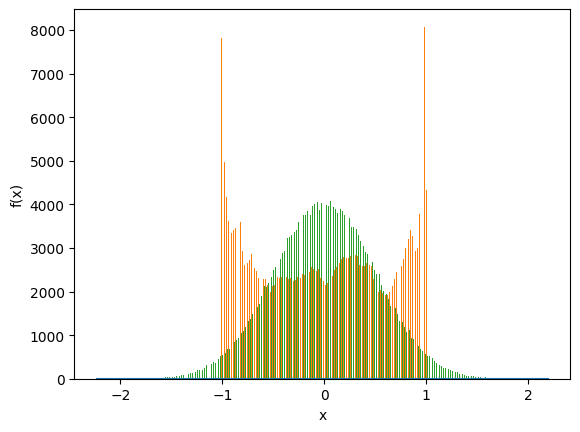

In [33]:
gaussian_reservoir_1.pre_train(X_TS, 0, 0)
gaussian_reservoir_1.predict(X_TS, save_gradients=False, save_states=True)
gaussian_reservoir_1.plot_global_neural_activity()

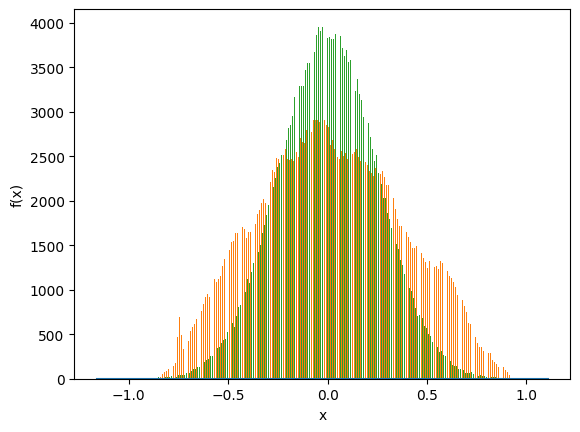

In [34]:
gaussian_reservoir_2.pre_train(X_TS, 0, 0)
gaussian_reservoir_2.predict(X_TS, save_gradients=False, save_states=True)
gaussian_reservoir_2.plot_global_neural_activity()

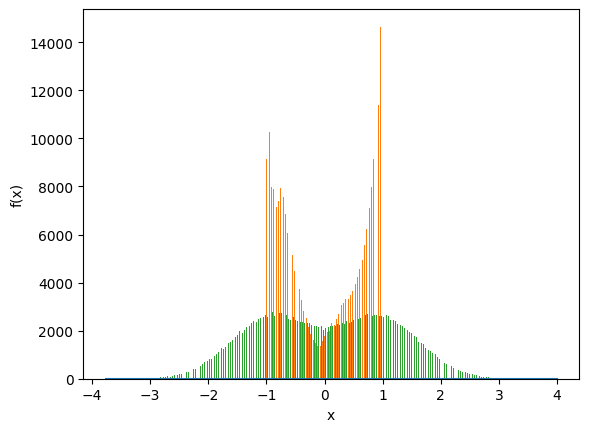

In [35]:
bimodal_reservoir.pre_train(X_TS, 0, 0)
bimodal_reservoir.predict(X_TS, save_gradients=False, save_states=True)
bimodal_reservoir.plot_global_neural_activity()

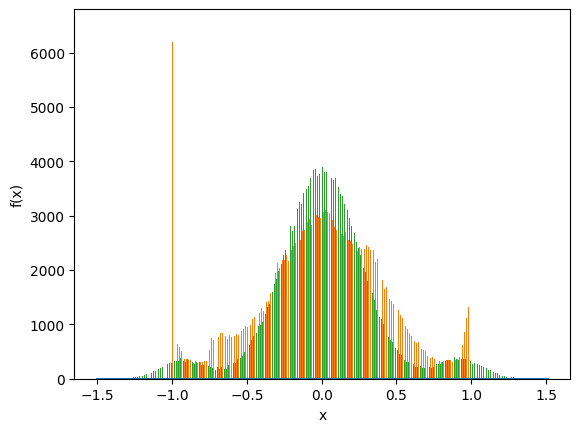

In [36]:
trimodal_reservoir_1.pre_train(X_TS, 0, 0)
trimodal_reservoir_1.predict(X_TS, save_gradients=False, save_states=True)
trimodal_reservoir_1.plot_global_neural_activity()

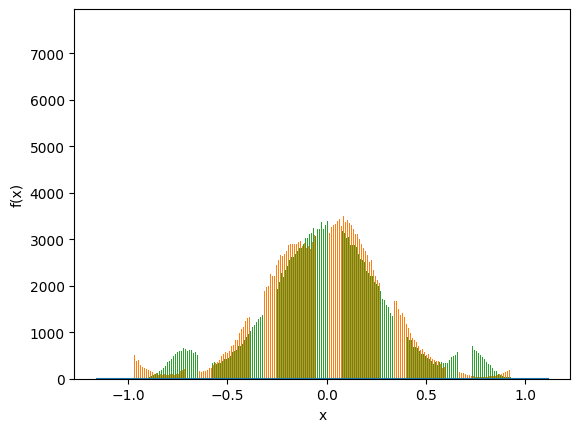

In [37]:
trimodal_reservoir_2.pre_train(X_TS, 0, 0)
trimodal_reservoir_2.predict(X_TS, save_gradients=False, save_states=True)
trimodal_reservoir_2.plot_global_neural_activity()

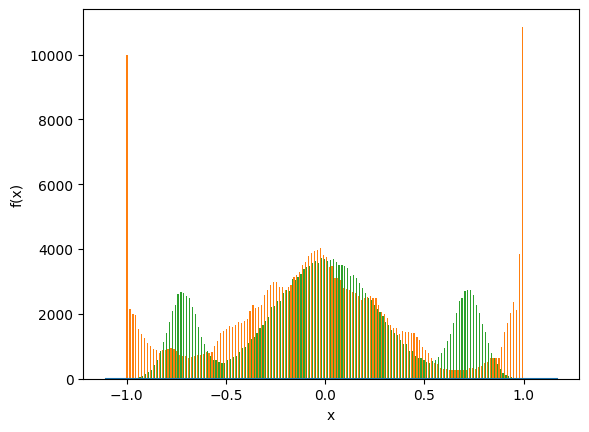

In [38]:
trimodal_reservoir_3.pre_train(X_TS, 0, 0)
trimodal_reservoir_3.predict(X_TS, save_gradients=False, save_states=True)
trimodal_reservoir_3.plot_global_neural_activity()